In [3]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import os
import math
import random
import imageio
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
import keras

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline

In [112]:
### DISTANCE BETWEEN 2 POINTS

def distance(point1, point2):
    x = math.sqrt((point2[1] - point1[1])**2 + (point2[0] - point1[0]) ** 2)
    return x

### SLOPE BETWEEN 2 POINTS

def slope(point1, point2):
    if point2[0] - point1[0] == 0:
        return 999999999
    x = (point1[1] - point2[1]) / (point2[0] - point1[0])
    return x

def distance_from_top(point):
    return point[1]

def distance_from_left(point):
    return point[0]

In [5]:
### EXERCISE CLASSIFICATIPON MODEL INITIALIZATION
def exercise_classification_init():
    model = keras.models.load_model("model_exp/")
    #model = keras.models.load_model("mega_model/")
    return model

In [13]:
### EXERCISE CLASSIFICATION
def exercise_classify(path, target_size=(100,100)):
    model = exercise_classification_init()
    class_names = ["BENCH", "SQUAT", "DEADLIFT"]

    img = keras.preprocessing.image.load_img(path, target_size=target_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    #print("This image most likely belongs to {} with {:.2f}% confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

    return class_names[np.argmax(score)]

In [7]:
### HPE NEURAL NET INITIALIZATION

def neural_net_init(mode):
    MODE = mode

    if MODE is "COCO":
        protoFile = "pose/coco/pose_deploy_linevec.prototxt"
        weightsFile = "pose/coco/pose_iter_440000.caffemodel"
        nPoints = 18
        POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

    elif MODE is "MPI" :
        protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
        weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
        nPoints = 15
        POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

    inWidth = 368
    inHeight = 368

    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

    inWidth = 368
    inHeight = 368
    
    return nPoints, POSE_PAIRS, net, inWidth, inHeight


In [18]:
def pose_detect(file):
    nPoints, POSE_PAIRS, net, inWidth, inHeight = neural_net_init("MPI")
    
    frame = cv2.imread(file)
    framePoints = np.copy(frame)
    frameSkeleton = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)

    output = net.forward()
    H = output.shape[2]
    W = output.shape[3]

    # Empty list to store the detected keypoints
    points = []

    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Scale the point to fit on the original image
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        if prob > threshold : 
            cv2.circle(framePoints, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(framePoints, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            cv2.circle(frameSkeleton, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameSkeleton, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else :
            points.append(None)

    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frameSkeleton, points[partA], points[partB], (0, 255, 255), 3)
    
    
    
    return framePoints, frameSkeleton, points

In [193]:
def form_feedback(path, points, exerciseType):
    frame = cv2.imread(path)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    good_form = True
    if exerciseType == "BENCH":
        print("Bench Feedback\n__________________\n")
        
        if all([points[12], points[11]]) and distance_from_top(points[12]) - distance_from_top(points[11]) < 0:
            print("Keep your feet planted on the ground! It will help increase your power.\n")
            good_form = False
        if (all([points[11], points[14]]) and distance(points[11], points[14]) < .1 * frameHeight):
            print("Your arch is a bit excessive. Keep your butt on the bench.\n")
            good_form = False
        if (all([points[2], points[4]]) and distance(points[2], points[4]) > (.2 * frameWidth)):
            print("Your arms are way too out in front of you. Keep them in line with your chest.\n")
            good_form = False
        
        
    elif exerciseType == "SQUAT":
        print("Squat Feedback\n__________________\n")
        
        #CAVED KNEES TEST
        if all([points[9], points[12], points[10], points[13]]) and distance(points[9], points[12]) < distance(points[10], points[13]):
            print("Your knees are too caved in. Use a lighter weight.\n")
            good_form = False
        if all([points[2], points[5]]) and abs(distance_from_top(points[2]) - distance_from_top(points[5])) > 10:
            print("Your shoulders are uneven. Stretch them out before lifting and consider lowering the weight.\n")
            good_form = False
        if all([points[9], points[10]]) and slope(points[9], points[10]) < .5:
            print("Your knees are too far out in front of you. Squat with your butt, not your knees!\n")
            good_form = False
        if points[0]:
            for p in points:
                if p and distance_from_top(points[0]) > distance_from_top(p):
                    print("DANGER! Your neck and back are curved in a way that will cause you grave injury. Please lower the weight, keep your neck and back straight, and try again!\n")
                    good_form = False
                    break
        else:
            print("DANGER! Your neck and back are curved in a way that will cause you grave injury. Please lower the weight, keep your neck and back straight, and try again!\n")
            good_form = False
        
    elif exerciseType == "DEADLIFT":
        print("Deadlift Feedback\n__________________\n")
        if all([points[14], points[0]]) and (slope(points[14], points[0]) < .5):
            print("Your back is way too curved. Consider lowering the weight. \n")
            good_form = False
        if (all([points[2], points[3]]) and abs(distance_from_left(points[2]) - distance_from_left(points[3])) > (.075 * frameWidth)):
            print("Your elbows are flaring out. Keep your arms in line with your shoulders.\n")
            good_form = False
        if points[0]:
            for p in points:
                if p and distance_from_top(points[0]) > distance_from_top(p):
                    print("DANGER! Your neck and back are curved in a way that will cause you grave injury. Please lower the weight, keep your neck and back straight, and try again!\n")
                    good_form = False
                    break
        else:
            print("DANGER! Your neck and back are curved in a way that will cause you grave injury. Please lower the weight, keep your neck and back straight, and try again!\n")
            good_form = False
        
          
    else:
        print("Invalid Exercise Type")
    
    if (good_form):
        print("All good! Keep at it!")

`
0 - HEAD
1 - FACE
2 - LEFT SHOULDER
3 - LEFT ELBOW
4 - LEFT WRIST
5 - RIGHT SHOULDER
6 - RIGHT ELBOW
7 - RIGHT WRIST
8 - LEFT WAIST
9 - LEFT KNEE
10 - LEFT ANKLE
11 - RIGHT WAIST
12 - RIGHT KNEE
13 - RIGHT ANKLE
14 - CHEST
`

Bench Feedback
__________________

Keep your feet planted on the ground! It will help increase your power.



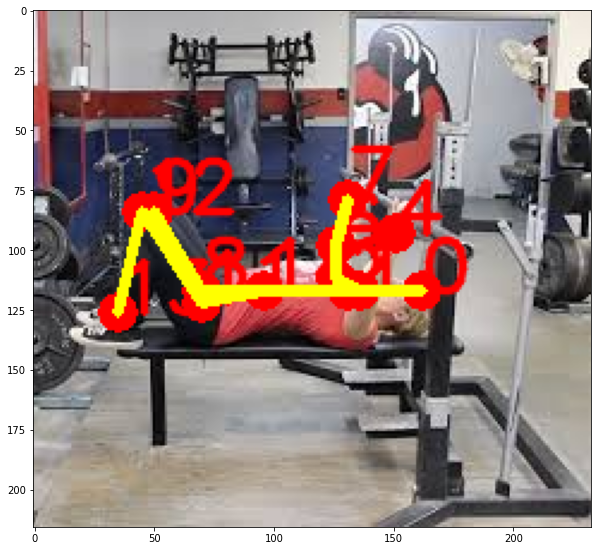

In [195]:
path = "bad_form/bench_1.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Bench Feedback
__________________

All good! Keep at it!


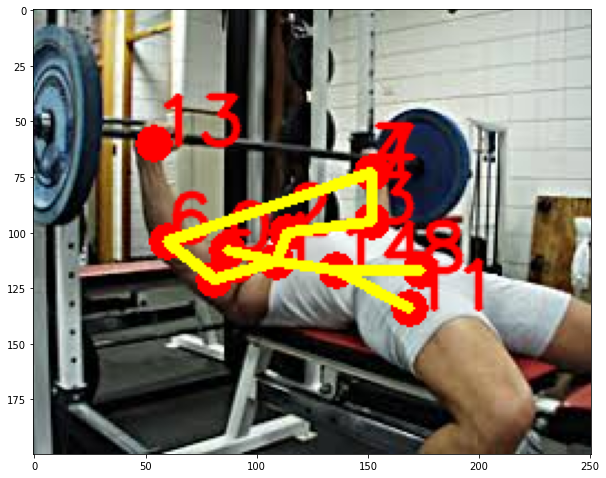

In [196]:
path = "good_form/bench_1.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Bench Feedback
__________________

Your arch is a bit excessive. Keep your butt on the bench.



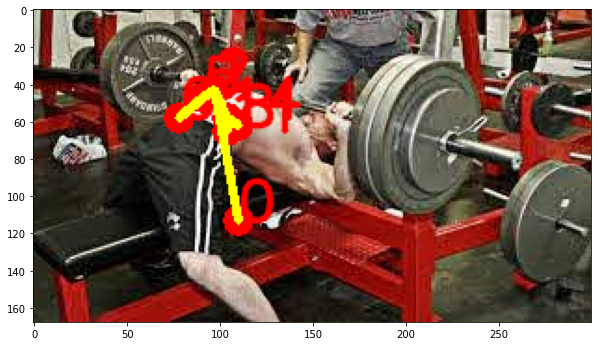

In [197]:
path = "bad_form/bench_3.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Bench Feedback
__________________

Your arms are way too out in front of you. Keep them in line with your chest.



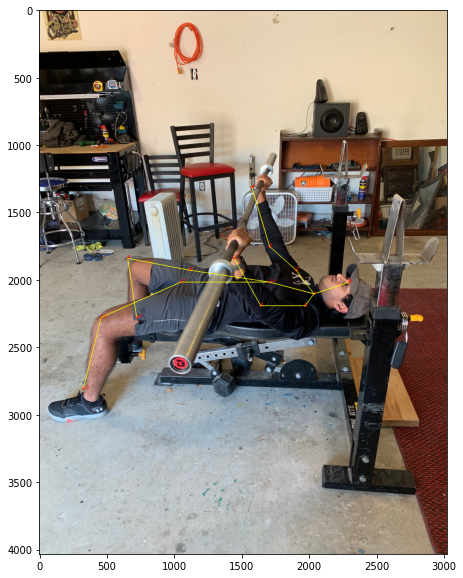

In [198]:
path = "bad_form/bench_4.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Deadlift Feedback
__________________

Your back is way too curved. Consider lowering the weight. 

DANGER! Your neck and back are curved in a way that will cause you grave injury. Please lower the weight, keep your neck and back straight, and try again!



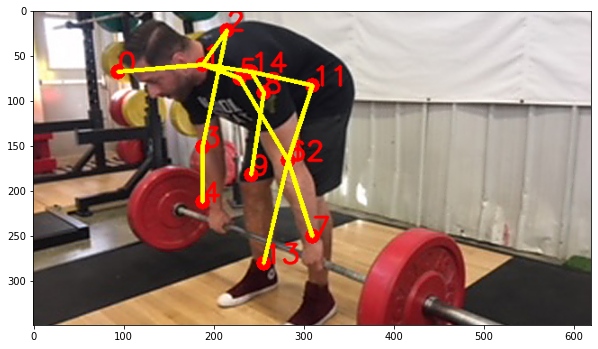

In [199]:
path = "bad_form/deadlift_2.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Deadlift Feedback
__________________

Your elbows are flaring out. Keep your arms in line with your shoulders.



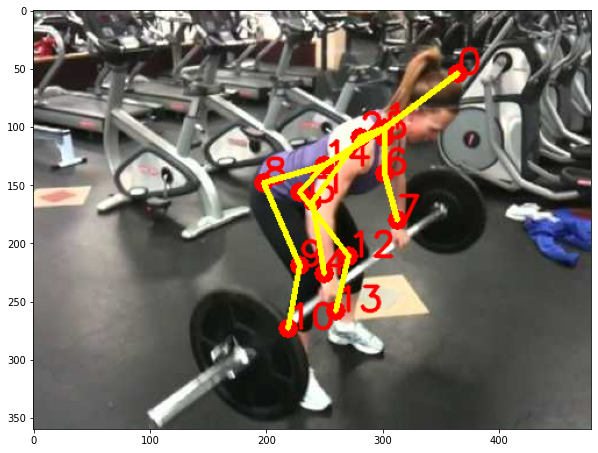

In [200]:
path = "bad_form/deadlift_6.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Deadlift Feedback
__________________

All good! Keep at it!


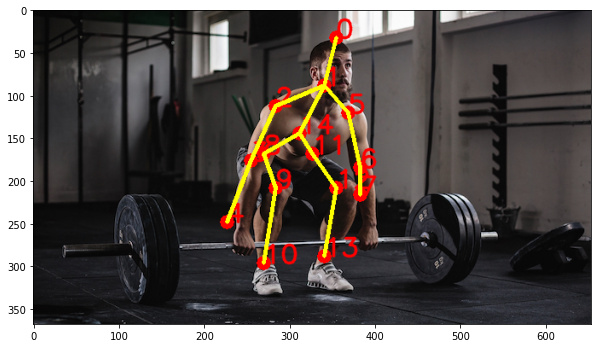

In [201]:
path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))
formFeedback = form_feedback(path, points, exerciseType)

Deadlift Feedback
__________________

All good! Keep at it!


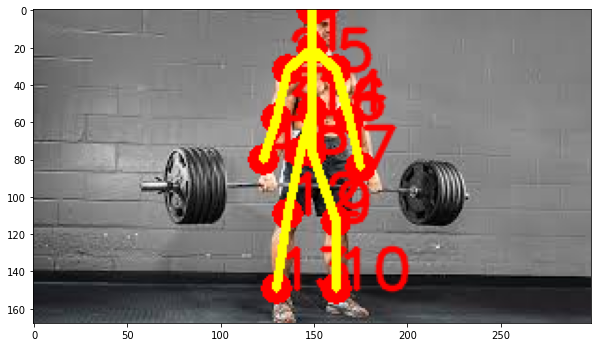

In [202]:
path = "good_form/deadlift_2.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))
formFeedback = form_feedback(path, points, exerciseType)

Deadlift Feedback
__________________

All good! Keep at it!


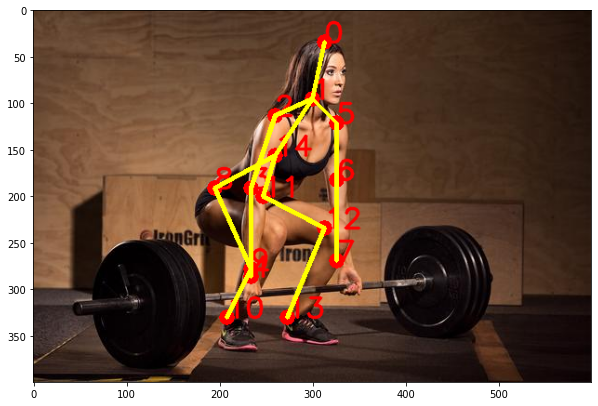

In [203]:
path = "good_form/deadlift_3.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))
formFeedback = form_feedback(path, points, exerciseType)

Squat Feedback
__________________

Your knees are too caved in. Use a lighter weight.

Your shoulders are uneven. Stretch them out before lifting and consider lowering the weight.



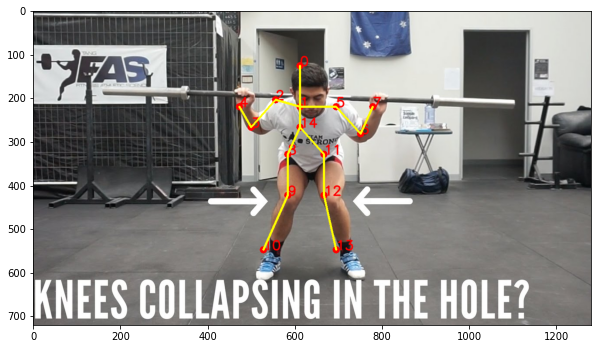

In [204]:
path = "bad_form/squat_1.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Squat Feedback
__________________

Your knees are too caved in. Use a lighter weight.



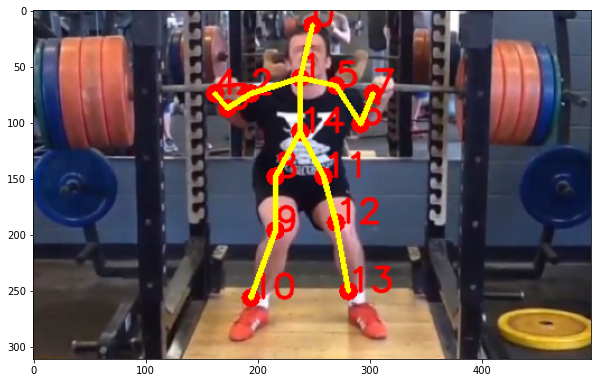

In [205]:
path = "bad_form/squat_2.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Squat Feedback
__________________

Your shoulders are uneven. Stretch them out before lifting and consider lowering the weight.

Your knees are too far out in front of you. Squat with your butt, not your knees!



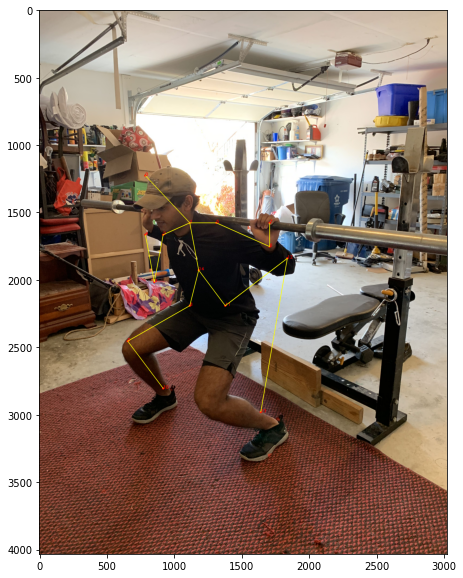

In [206]:
path = "bad_form/squat_3.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Squat Feedback
__________________

Your knees are too caved in. Use a lighter weight.

Your shoulders are uneven. Stretch them out before lifting and consider lowering the weight.

DANGER! Your neck and back are curved in a way that will cause you grave injury. Please lower the weight, keep your neck and back straight, and try again!



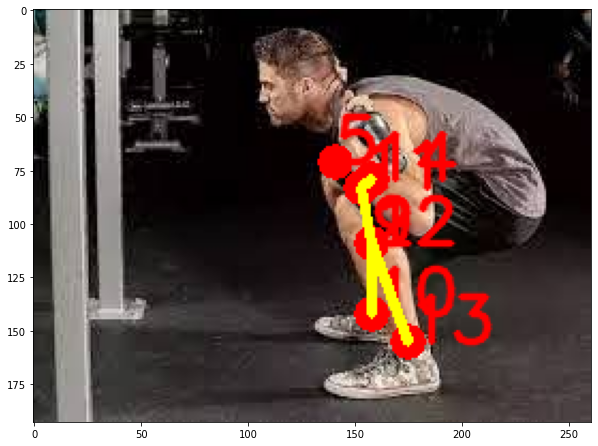

In [207]:
path = "bad_form/squat_4.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Squat Feedback
__________________

Your knees are too caved in. Use a lighter weight.



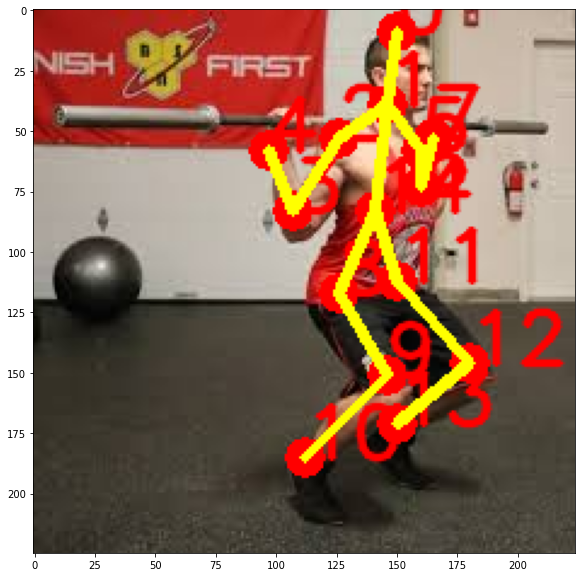

In [208]:
path = "bad_form/squat_5.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)

Squat Feedback
__________________

Your knees are too far out in front of you. Squat with your butt, not your knees!



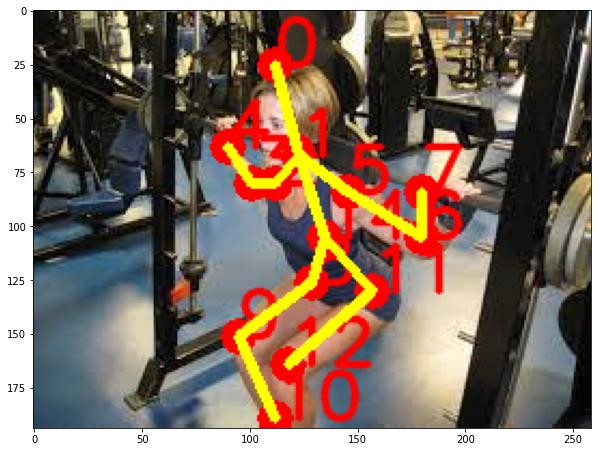

In [209]:
path = "bad_form/squat_6.jpg"
#path = "good_form/deadlift_1.jpg"
framePoints, frameSkeleton, points = pose_detect(path)
exerciseType = exercise_classify(path)
#plt.figure(figsize=[10,10])
#plt.imshow(cv2.cvtColor(framePoints, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameSkeleton, cv2.COLOR_BGR2RGB))

formFeedback = form_feedback(path, points, exerciseType)